In [2]:
import pandas as pd 
import csv
import requests
import numpy as np
import matplotlib.pyplot as plt

import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    matthews_corrcoef
)
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC

from scikeras.wrappers import KerasClassifier

from sklearn.naive_bayes import GaussianNB

from interpret.glassbox import ExplainableBoostingClassifier

from sklearn.neighbors import KNeighborsClassifier

#from autogluon.tabular import TabularPredictor

In [3]:
# Importer la data
K2 = pd.read_csv('K2.csv')
KOI = pd.read_csv('KOI.csv')
TOI = pd.read_csv('TOI.csv')
K2['transit_dur'] = np.nan

#Transit_depth K2
K2['transit_depth'] = ((K2['pl_rade']*(0.009157))/K2['st_rad'])**2 


# Label
map = {
    "FP" : "FALSE POSITIVE",
    "PC" : "CANDIDATE",
    "KP" : "CONFIRMED",
    "APC" : "CANDIDATE",
    "FA" : "FALSE POSITIVE",
    "CP" : "CONFIRMED"
}
TOI["tfopwg_disp"] = TOI["tfopwg_disp"].replace(map)


def colonne(name1, name2, name3):
    merged = pd.concat([TOI[name1], KOI[name2], K2[name3]], ignore_index = True, axis = 0) 
    df = pd.DataFrame(merged)
    return df 


# On crée nos grandes colonnes
cY = colonne('tfopwg_disp', 'koi_disposition', 'disposition')
cTemp = colonne('pl_eqt', 'koi_teq', 'pl_eqt')
cTransitDepth = colonne('pl_trandep', 'koi_depth', 'transit_depth')
cTransitDur = colonne('pl_trandurh', 'koi_duration', 'transit_dur')
cMagn = colonne('st_tmag', 'koi_kepmag', 'sy_vmag')
cRadius = colonne('pl_rade', 'koi_prad', 'pl_rade')
cOrb = colonne('pl_orbper', 'koi_period', 'pl_orbper')
#cMass = colonne('st_mass', 'koi_mass', 'st_mass')
cRadSt = colonne('st_rad', 'koi_srad', 'st_rad')
cTeff = colonne('st_teff', 'koi_steff', 'st_teff')
cLogg = colonne('st_logg', 'koi_slogg', 'st_logg')
#cInsol = colonne('pl_insol', 'koi_insol', 'pl_insol')
#cDens = colonne('pl_dens', 'koi_dens', 'pl_dens')

 

# On crée notre giga tableau
final_df = pd.concat(
    [
        cY,              # disposition / label
        cTemp,           # température d’équilibre planétaire
        cTransitDepth,   # profondeur du transit
        cTransitDur,     # durée du transit
        cMagn,           # magnitude stellaire
        cRadius,         # rayon planétaire
        cOrb,            # période orbitale
        cRadSt,          # rayon stellaire
        cTeff,           # température stellaire
        cLogg,           # gravité de surface
        # (st_mass retirée car incomplète)
    ],
    axis=1,
    ignore_index=True
)

final_df.columns = [
    'disposition',      # label
    'températureeq',
    'transit_depth',
    'transit_dur',
    'Magnitude',
    'Radius',
    'cOrb',
    'cRadSt',
    'cTeff',
    'cLogg',
]



# Création de nouvelles features physiques dérivées
final_df['ratio_Rp_Rs'] = final_df['Radius'] / (final_df['cRadSt'] + 1e-6)
final_df['log_period'] = np.log1p(final_df['cOrb'])
final_df['depth_dur_ratio'] = final_df['transit_depth'] / (final_df['transit_dur'] + 1e-6)
final_df['ratio_Teff_Eqt'] = final_df['cTeff'] / (final_df['températureeq'] + 1e-6) # pour éviter de diviser par 0 et pout le log


y = final_df.disposition
X = final_df.drop(columns = 'disposition')

# Traiter le Label
map2 = {"REFUTED" : "FALSE POSITIVE"}
y = y.replace(map2)

le = LabelEncoder()
y = le.fit_transform(y)


# On sépare notre data pour ne pas tricher et valider le modèle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train_plus = X_train.copy()
X_test_plus = X_test.copy()

# StandardScaler car des valeurs sont très grandes 
scaler = StandardScaler()

scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train))
scaled_X_test = pd.DataFrame(scaler.transform(X_test))

scaled_X_train.columns = X_train_plus.columns
scaled_X_test.columns = X_test_plus.columns


X_train = scaled_X_train
X_test = scaled_X_test

# Traiter les NaN
X_train_plus = X_train.copy()
X_test_plus = X_test.copy()

cwmv = [col for col in X.columns if X[col].isnull().any()]

for col in cwmv:
    X_train_plus[col + '_was_missing'] = X_train_plus[col].isnull()
    X_test_plus[col + '_was_missing'] = X_test_plus[col].isnull()
    

imput = SimpleImputer()

imp_X_train = pd.DataFrame(imput.fit_transform(X_train_plus))
imp_X_test = pd.DataFrame(imput.transform(X_test_plus))


imp_X_train.columns = X_train_plus.columns
imp_X_test.columns = X_test_plus.columns


X_train = imp_X_train
X_test = imp_X_test

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


<Axes: >

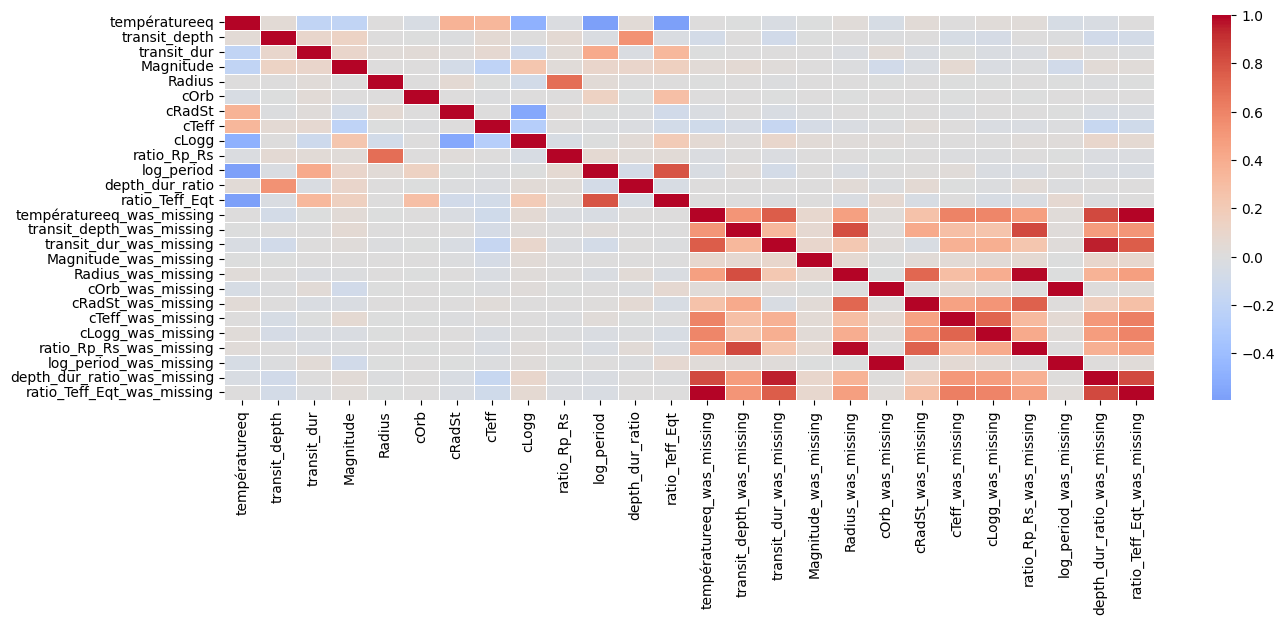

In [4]:
# Matrice de confusion pour voir la corrélation entre les features
import seaborn as sns

corr_matrix = X_train.corr()

plt.figure(figsize =(15,5))
sns.heatmap(
    corr_matrix,
    annot = False,
    cmap = 'coolwarm',
    center = 0,
    linewidths = 0.5
)

In [5]:
# Let's start the Stacking process !

# Base Learners :


# 1 - XBG avec es

xgb = XGBClassifier(
    random_state = 1,
    n_estimators = 444,
    max_depth = 6,
    eval_metric = 'mlogloss',
    objective='multi:softprob',
    num_class=3,
    learning_rate = 0.05,
    )


# 2 - RandomForest

rf = RandomForestClassifier(
    n_estimators = 460,
    max_depth = 10,
    random_state = 42
)

# 3 - LogisticRegression

lr = LogisticRegression(
    multi_class='multinomial',   # softmax général
    solver='lbfgs',              #  Le solver est l’algorithme qui descend cette fonction de coût pour la minimiser.
    max_iter=1000,               # augmente pour éviter le warning de convergence
    C=1,                         # inverse de la régularisation (plus petit = plus régularisé)
    class_weight='balanced',     # utile si les classes sont un peu déséquilibrées (légerment le cas ici)
    random_state=42
)

# 4 - SVC (orthogonal à XGB) : construit une surface de séparation lisse entre les classes. (à revoir car complexe)

svc = SVC(
    probability = True,
    class_weight = 'balanced',
    random_state = 42
)

# 5 - NN (with wrapper) : apprend une fonction complexe qui combine toutes les features en même temps (interactions implicites).
 
def build_nn(input_shape):
    model = keras.Sequential([
        layers.BatchNormalization(input_shape=input_shape),

        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(3, activation='softmax')
    ])
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model


nn = KerasClassifier(
    model=build_nn,
    model__input_shape=([X_train.shape[1]]),
    batch_size=128,
    epochs=45,
)

# 6 - Gaussian Naives bayes : classe chaque point selon la probabilité qu’il appartienne à une classe, en supposant que chaque feature suit une loi normale indépendante dans chaque classe

gnb = GaussianNB() # verra plus tard pour les hyperparamètres

# 7 - EBM : L’EBM (ou GAM Boosté) est un modèle additif interprétable ,chaque variable influence la prédiction selon une courbe que je vais apprendre.

ebm = ExplainableBoostingClassifier()

# 8 - KNN : Le kNN observe les petits “nuages de points” dans l’espace des features

knn = KNeighborsClassifier()



In [ ]:
from sklearn.ensemble import StackingClassifier

base_learners = [
    ('xgb', xgb),
    ('rf', rf),
    ('lr', lr),
    ('svc', svc)
    ('nn', nn),
    ('gnb', gnb),
    ('ebm', ebm),
    ('knn', knn)
]

meta_model = XGBClassifier()

# Stacking 
stacked_model = StackingClassifier(
    estimators = base_learners,
    final_estimator = meta_model,
    passthrough=True,
    stack_method='predict_proba',
    cv = 3,
    n_jobs = -1
)

stacked_model.fit(X_train, y_train)

,estimators,"[('xgb', ...), ('rf', ...), ...]"
,final_estimator,"XGBClassifier...ree=None, ...)"
,cv,3
,stack_method,'predict_proba'
,n_jobs,-1
,passthrough,True
,verbose,0
,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy : 0.7438
Precision: 0.7437
Recall   : 0.7438
F1-score : 0.7437
Matt score :  0.6118

Rapport complet :
                precision    recall  f1-score   support

     CANDIDATE       0.72      0.72      0.72      1704
     CONFIRMED       0.77      0.78      0.78      1286
FALSE POSITIVE       0.75      0.73      0.74      1265

      accuracy                           0.74      4255
     macro avg       0.75      0.75      0.75      4255
  weighted avg       0.74      0.74      0.74      4255



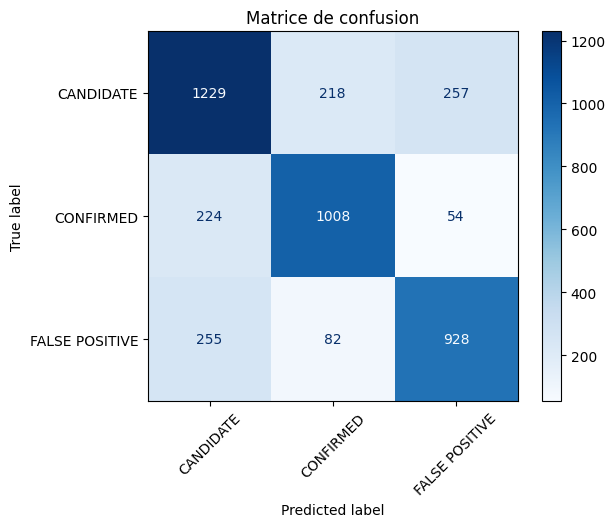

In [7]:
y_pred = stacked_model.predict(X_test)

# 1️ Accuracy = pourcentage de bonnes prédictions
# -> utile pour avoir une vue globale de la performance
acc = accuracy_score(y_test, y_pred)

# 2️ Precision = parmi les prédictions positives, combien sont correctes
# -> "fiabilité" du modèle quand il dit qu’un échantillon est d’une classe donnée
prec = precision_score(y_test, y_pred, average='weighted')

# 3️ Recall = parmi les vraies occurrences positives, combien ont été trouvées
# -> "sensibilité" du modèle, important pour ne pas rater des exoplanètes réelles
rec = recall_score(y_test, y_pred, average='weighted')

# 4️ F1-score = moyenne harmonique entre précision et recall
# -> équilibre entre ne pas rater (recall) et ne pas se tromper (precision)
f1 = f1_score(y_test, y_pred, average='weighted')

mat = matthews_corrcoef(y_test, y_pred)

# On affiche le résumé global
print("Accuracy :", round(acc, 4))
print("Precision:", round(prec, 4))
print("Recall   :", round(rec, 4))
print("F1-score :", round(f1, 4))
print("Matt score : ", round(mat, 4))

# 5️ Classification report complet (par classe)
# -> très utile pour voir les performances détaillées classe par classe
print("\nRapport complet :")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 6 Matrice de confusion (visualisation des erreurs)
# -> montre quelles classes sont confondues entre elles
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matrice de confusion")
plt.show()
